In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
np.random.seed(42)

In [4]:
X = pd.read_csv('./anomaly-class-detection/train/train.csv')
y = X.pop('result')
X

,exchange,RSI,RSI_signal,ATR,EMA_relative,MA_relative,SMA_relative,WMA_relative,MACD,MACD_relative,...,Bollinger_upper_band,Bollinger_lower_band,Bollinger_signal,ichimoku_c_conversion_line,ichimoku_c_base_line,ichimoku_c_leading_span_a,ichimoku_c_leading_span_b,ichimoku_c_signal,SAR_relative,s&p500_move_15m
0,BC,32.000000,Hold,0.000347,1.002286,1.002714,-0.270648,-0.002280,-0.000136,-0.000455,...,0.001013,-0.006569,Hold,2.168836e-01,0.166834,0.417084,0.483817,Sell,0.282722,-2.927393
1,BC,48.648649,Hold,0.000513,0.998955,0.999231,0.076998,0.001080,-0.000196,-0.000613,...,0.004261,-0.003543,Hold,-9.357455e-02,-0.093575,-0.015596,-0.171553,Buy,-0.086598,-4.592614
2,BC,21.428571,Buy,0.000413,1.002658,1.003332,-0.332120,-0.002628,-0.000412,-0.001321,...,0.001150,-0.008747,Hold,2.723486e-01,0.608779,0.368472,-0.144185,Buy,0.286055,-0.833371
3,BC,38.297872,Hold,0.000527,1.000234,1.000465,-0.046505,-0.000180,-0.000282,-0.000936,...,0.001933,-0.004423,Hold,-4.985045e-02,0.099701,0.324028,0.598205,Sell,0.113799,-1.242264
4,BC,37.566138,Hold,0.002780,1.001247,1.001720,-0.171722,-0.001204,0.000670,0.002009,...,0.024233,-0.024503,Hold,-3.000300e-02,-0.765077,-5.670567,-5.205521,Sell,0.250892,-0.786651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335035,BC,69.444444,Hold,0.005533,0.997982,0.997487,0.251931,0.002051,0.003619,0.000988,...,0.006880,-0.000990,Hold,-2.321770e-01,-0.355094,-0.273149,-0.382409,Buy,-0.294609,-0.131818
3335036,BC,56.000000,Hold,0.003200,0.997922,0.998137,0.186683,0.002220,-0.001749,-0.001086,...,0.005385,-0.002959,Hold,-2.795031e-01,-0.062112,0.496894,0.496894,Buy,-0.340927,-0.546764
3335037,OK,48.333333,Hold,7.266667,1.001335,1.001346,-0.134441,-0.001342,1.216706,0.000175,...,0.003247,-0.005668,Hold,1.370258e-01,-0.072119,-0.641858,-0.771672,Buy,0.106855,-0.005045
3335038,OK,50.000000,Hold,0.000167,1.000667,1.000684,-0.068329,-0.000695,-0.000009,-0.000066,...,0.004315,-0.005486,Hold,1.098901e-01,0.109890,-0.787546,-0.586081,Sell,0.046107,-0.308752


In [5]:
X_test = pd.read_csv('./anomaly-class-detection/test.csv', index_col='id')
index_col = X_test.index
X_test

,exchange,RSI,RSI_signal,ATR,EMA_relative,MA_relative,SMA_relative,WMA_relative,MACD,MACD_relative,...,Bollinger_upper_band,Bollinger_lower_band,Bollinger_signal,ichimoku_c_conversion_line,ichimoku_c_base_line,ichimoku_c_leading_span_a,ichimoku_c_leading_span_b,ichimoku_c_signal,SAR_relative,s&p500_move_15m
id,,,,,,,,,,,,,,,,,,,,,
0,BC,55.265610,Hold,13.913333,1.000181,1.000026,-0.002551,-0.000239,10.689502,0.000405,...,0.001787,-0.001383,Hold,0.065536,-0.005303,-0.122169,-0.128040,Buy,0.052812,-0.173499
1,BC,30.530973,Hold,15.593333,1.000436,1.000603,-0.060300,-0.000418,-13.493144,-0.000512,...,0.000733,-0.002635,Hold,0.057680,0.181010,0.051419,0.108530,Sell,0.060480,-0.193533
2,BC,29.121726,Buy,17.486667,1.000794,1.001058,-0.105689,-0.000766,-14.701974,-0.000559,...,0.000196,-0.002939,Hold,0.081365,0.157408,0.304075,0.302649,Buy,0.076881,-0.060834
3,BC,27.715356,Buy,10.286667,1.000553,1.000700,-0.069978,-0.000566,-7.428207,-0.000283,...,0.000732,-0.002377,Hold,0.074947,0.104242,0.418012,0.363704,Buy,0.075752,0.018642
4,BC,46.851211,Hold,12.566667,1.000236,1.000358,-0.035742,-0.000217,-4.157181,-0.000158,...,0.001202,-0.001777,Hold,0.005706,0.056295,0.297737,0.372765,Sell,0.034349,0.243439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114577,HB,41.750842,Hold,0.000290,1.000577,1.000578,-0.057781,-0.000582,-0.000120,-0.000566,...,0.004314,-0.006879,Hold,0.111364,0.206142,1.088759,1.023600,Buy,0.054950,-0.316902
114578,HB,25.870647,Buy,0.000279,1.000733,1.001560,-0.155732,-0.000622,-0.000312,-0.001483,...,0.003349,-0.007838,Hold,0.126016,0.259166,1.222122,1.562128,Sell,0.102489,0.065787
114579,HB,66.836735,Hold,0.000294,0.998322,0.997801,0.220414,0.001672,0.000216,0.001023,...,0.007390,-0.001571,Hold,-0.156191,-0.265051,0.308832,0.939512,Sell,-0.214776,0.126512


In [6]:
cat_desc = X.describe(include='object')
cat_desc

,exchange,RSI_signal,Stoch_O_signal,fibonacci_signal,Bollinger_signal,ichimoku_c_signal
count,3335040,3335040,3335040,3335040,3335040,3335040
unique,4,3,3,3,3,3
top,BB,Hold,Sell,Sell,Hold,Buy
freq,1201702,2452197,3062281,1697351,3076880,1665849


In [7]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X[cat_desc.columns.to_list()] = ordinal_encoder.fit_transform(X[cat_desc.columns.to_list()])
X

,exchange,RSI,RSI_signal,ATR,EMA_relative,MA_relative,SMA_relative,WMA_relative,MACD,MACD_relative,...,Bollinger_upper_band,Bollinger_lower_band,Bollinger_signal,ichimoku_c_conversion_line,ichimoku_c_base_line,ichimoku_c_leading_span_a,ichimoku_c_leading_span_b,ichimoku_c_signal,SAR_relative,s&p500_move_15m
0,1.0,32.000000,1.0,0.000347,1.002286,1.002714,-0.270648,-0.002280,-0.000136,-0.000455,...,0.001013,-0.006569,1.0,2.168836e-01,0.166834,0.417084,0.483817,2.0,0.282722,-2.927393
1,1.0,48.648649,1.0,0.000513,0.998955,0.999231,0.076998,0.001080,-0.000196,-0.000613,...,0.004261,-0.003543,1.0,-9.357455e-02,-0.093575,-0.015596,-0.171553,0.0,-0.086598,-4.592614
2,1.0,21.428571,0.0,0.000413,1.002658,1.003332,-0.332120,-0.002628,-0.000412,-0.001321,...,0.001150,-0.008747,1.0,2.723486e-01,0.608779,0.368472,-0.144185,0.0,0.286055,-0.833371
3,1.0,38.297872,1.0,0.000527,1.000234,1.000465,-0.046505,-0.000180,-0.000282,-0.000936,...,0.001933,-0.004423,1.0,-4.985045e-02,0.099701,0.324028,0.598205,2.0,0.113799,-1.242264
4,1.0,37.566138,1.0,0.002780,1.001247,1.001720,-0.171722,-0.001204,0.000670,0.002009,...,0.024233,-0.024503,1.0,-3.000300e-02,-0.765077,-5.670567,-5.205521,2.0,0.250892,-0.786651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335035,1.0,69.444444,1.0,0.005533,0.997982,0.997487,0.251931,0.002051,0.003619,0.000988,...,0.006880,-0.000990,1.0,-2.321770e-01,-0.355094,-0.273149,-0.382409,0.0,-0.294609,-0.131818
3335036,1.0,56.000000,1.0,0.003200,0.997922,0.998137,0.186683,0.002220,-0.001749,-0.001086,...,0.005385,-0.002959,1.0,-2.795031e-01,-0.062112,0.496894,0.496894,0.0,-0.340927,-0.546764
3335037,3.0,48.333333,1.0,7.266667,1.001335,1.001346,-0.134441,-0.001342,1.216706,0.000175,...,0.003247,-0.005668,1.0,1.370258e-01,-0.072119,-0.641858,-0.771672,0.0,0.106855,-0.005045
3335038,3.0,50.000000,1.0,0.000167,1.000667,1.000684,-0.068329,-0.000695,-0.000009,-0.000066,...,0.004315,-0.005486,1.0,1.098901e-01,0.109890,-0.787546,-0.586081,2.0,0.046107,-0.308752


In [8]:
#using same ordinal_encoder object to transform test set
X_test[cat_desc.columns.to_list()] = ordinal_encoder.transform(X_test[cat_desc.columns.to_list()])
X_test


,exchange,RSI,RSI_signal,ATR,EMA_relative,MA_relative,SMA_relative,WMA_relative,MACD,MACD_relative,...,Bollinger_upper_band,Bollinger_lower_band,Bollinger_signal,ichimoku_c_conversion_line,ichimoku_c_base_line,ichimoku_c_leading_span_a,ichimoku_c_leading_span_b,ichimoku_c_signal,SAR_relative,s&p500_move_15m
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,55.265610,1.0,13.913333,1.000181,1.000026,-0.002551,-0.000239,10.689502,0.000405,...,0.001787,-0.001383,1.0,0.065536,-0.005303,-0.122169,-0.128040,0.0,0.052812,-0.173499
1,1.0,30.530973,1.0,15.593333,1.000436,1.000603,-0.060300,-0.000418,-13.493144,-0.000512,...,0.000733,-0.002635,1.0,0.057680,0.181010,0.051419,0.108530,2.0,0.060480,-0.193533
2,1.0,29.121726,0.0,17.486667,1.000794,1.001058,-0.105689,-0.000766,-14.701974,-0.000559,...,0.000196,-0.002939,1.0,0.081365,0.157408,0.304075,0.302649,0.0,0.076881,-0.060834
3,1.0,27.715356,0.0,10.286667,1.000553,1.000700,-0.069978,-0.000566,-7.428207,-0.000283,...,0.000732,-0.002377,1.0,0.074947,0.104242,0.418012,0.363704,0.0,0.075752,0.018642
4,1.0,46.851211,1.0,12.566667,1.000236,1.000358,-0.035742,-0.000217,-4.157181,-0.000158,...,0.001202,-0.001777,1.0,0.005706,0.056295,0.297737,0.372765,2.0,0.034349,0.243439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114577,2.0,41.750842,1.0,0.000290,1.000577,1.000578,-0.057781,-0.000582,-0.000120,-0.000566,...,0.004314,-0.006879,1.0,0.111364,0.206142,1.088759,1.023600,0.0,0.054950,-0.316902
114578,2.0,25.870647,0.0,0.000279,1.000733,1.001560,-0.155732,-0.000622,-0.000312,-0.001483,...,0.003349,-0.007838,1.0,0.126016,0.259166,1.222122,1.562128,2.0,0.102489,0.065787
114579,2.0,66.836735,1.0,0.000294,0.998322,0.997801,0.220414,0.001672,0.000216,0.001023,...,0.007390,-0.001571,1.0,-0.156191,-0.265051,0.308832,0.939512,2.0,-0.214776,0.126512


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

EDA

Our dataset is imbalanced

In [10]:
y.value_counts()

1    2970418
0     364622
Name: result, dtype: int64

Given that our training set is imbalanced, we can use alternative metrics to measure performance of different classifiers (e.g f1)

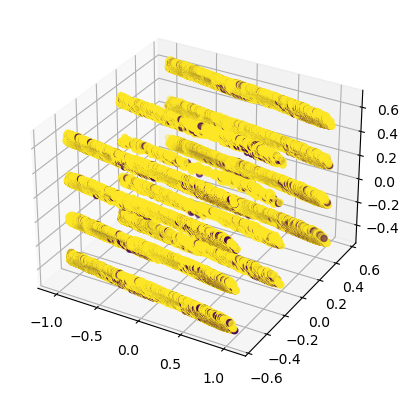

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y)
plt.show()


Model Performance and Evaluation

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, n_jobs=-1, scoring='f1_macro')
grid.fit(X, y)
grid.best_score_

0.47232641306207973

In [14]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, n_jobs=-1, scoring='f1_macro')
grid.fit(X, y)
grid.best_score_

0.780291284208259

In [ ]:
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7],
              'priors': [None, [0.5, 0.5], [0.4, 0.6]]}
grid = GridSearchCV(GaussianNB(), param_grid, refit=True, n_jobs=-1, scoring='f1_macro')
grid.fit(X, y)
grid.best_score_

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {'max_depth': [None, 5, 7, 10],
              'max_features': [None, 'sqrt', 'log2'],
              'min_samples_split': [2, 3, 4, 9]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, n_jobs=-1, scoring='f1_macro')
grid.fit(X, y)
grid.best_score_

In [ ]:
from sklearn.neural_network import MLPClassifier
param_grid = {'hidden_layer_sizes': [(100,), (200,), (30,)],
              'activation': ['relu', 'tanh', 'logistic', 'identity'],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'max_iter': [2000]}
grid = GridSearchCV(MLPClassifier(), param_grid, refit=True, n_jobs=-1, scoring='f1_macro')
grid.fit(X, y)
grid.best_score_